In [1]:
# It is a way to do hierarchical modelling in case of linear regression.

In [2]:
library("car")
data("Leinhardt")
?Leinhardt
str(Leinhardt)

'data.frame':	105 obs. of  4 variables:
 $ income: int  3426 3350 3346 4751 5029 3312 3403 5040 2009 2298 ...
 $ infant: num  26.7 23.7 17 16.8 13.5 10.1 12.9 20.4 17.8 25.7 ...
 $ region: Factor w/ 4 levels "Africa","Americas",..: 3 4 4 2 4 4 4 4 4 4 ...
 $ oil   : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...


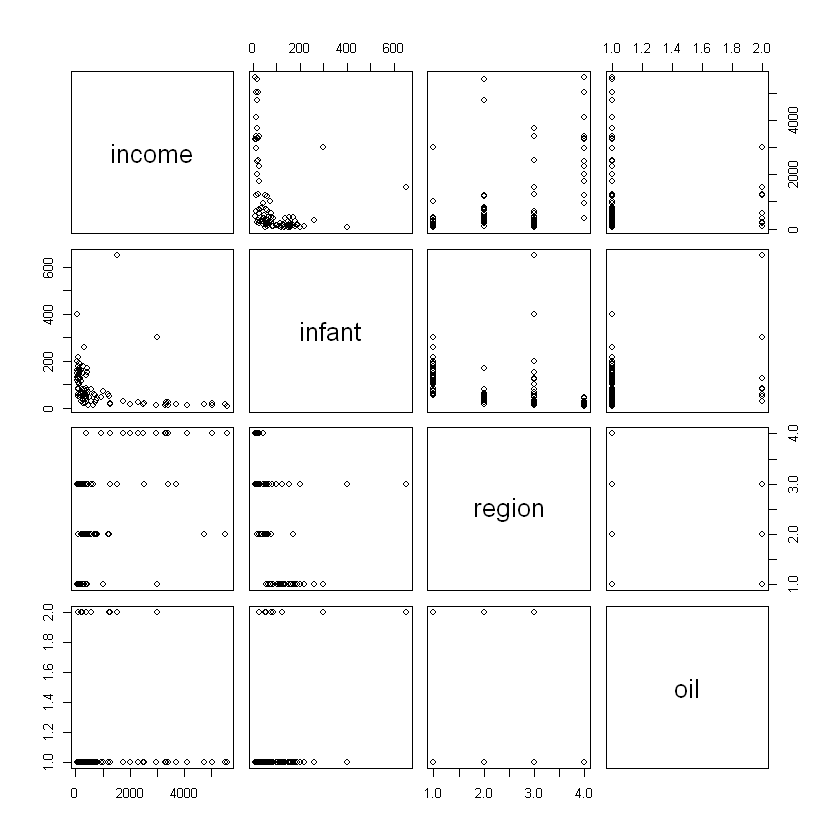

In [3]:
pairs(Leinhardt)

In [4]:
head(Leinhardt)

,income,infant,region,oil
Australia,3426,26.7,Asia,no
Austria,3350,23.7,Europe,no
Belgium,3346,17.0,Europe,no
Canada,4751,16.8,Americas,no
Denmark,5029,13.5,Europe,no
Finland,3312,10.1,Europe,no


In [5]:
dat = na.omit(Leinhardt)
dat$logincome = log(dat$income)
dat$loginfant = log(dat$infant)
str(dat)

'data.frame':	101 obs. of  6 variables:
 $ income   : int  3426 3350 3346 4751 5029 3312 3403 5040 2009 2298 ...
 $ infant   : num  26.7 23.7 17 16.8 13.5 10.1 12.9 20.4 17.8 25.7 ...
 $ region   : Factor w/ 4 levels "Africa","Americas",..: 3 4 4 2 4 4 4 4 4 4 ...
 $ oil      : Factor w/ 2 levels "no","yes": 1 1 1 1 1 1 1 1 1 1 ...
 $ logincome: num  8.14 8.12 8.12 8.47 8.52 ...
 $ loginfant: num  3.28 3.17 2.83 2.82 2.6 ...
 - attr(*, "na.action")=Class 'omit'  Named int [1:4] 24 83 86 91
  .. ..- attr(*, "names")= chr [1:4] "Iran" "Haiti" "Laos" "Nepal"


In [6]:
library("rjags")
library("coda")

Warning message:
"package 'rjags' was built under R version 3.4.4"Loading required package: coda
Warning message:
"package 'coda' was built under R version 3.4.4"Linked to JAGS 4.3.0
Loaded modules: basemod,bugs


In [7]:
model_string = " model {
    for (i in 1:length(y)) {
        y[i] ~ dnorm(mu[i], prec)
        mu[i] = a[region[i]] + b[1]*log_income[i] + b[2]*is_oil[i]
    }

    for (j in 1:max(region)) {
        a[j] ~ dnorm(a0, prec_a)
    }

    a0 ~ dnorm(0.0, 1.0/1.0e6)
    prec_a ~ dgamma(1/2.0, 1*10.0/2.0)
    tau = sqrt( 1.0 / prec_a )

    for (j in 1:2) {
        b[j] ~ dnorm(0.0, 1.0/1.0e6)
    }

    prec ~ dgamma(5/2.0, 5*10.0/2.0)
    sig = sqrt( 1.0 / prec )
} "

In [8]:
set.seed(116)

In [9]:
data_jags = list(y=dat$loginfant, 
                 log_income=dat$logincome,
                 is_oil=as.numeric(dat$oil=="yes"), 
                 region=as.numeric(dat$region))

In [10]:
data_jags$is_oil

[1] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0
 [38] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [75] 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

In [11]:
# One other important thing to check is whether all of the oil exporting countries are within a single region.
# If that were the case, our model could potentially suffer from confounding because we wouldn't know whether 
# it's the oil variable or the region variable that's affecting, that is potentially explaining some of the 
# variability in infant mortality. It looks like this is not the case.

table(data_jags$is_oil, data_jags$region)

   
     1  2  3  4
  0 31 20 24 18
  1  3  2  3  0

In [12]:
params = c("a0", "a", "b", "sig", "tau")

mod = jags.model(textConnection(model_string), 
                 data=data_jags, 
                 n.chains=3)

update(mod, 1e3) # burn-in

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 101
   Unobserved stochastic nodes: 9
   Total graph size: 622

Initializing model



In [13]:
mod_sim = coda.samples(model=mod,
                       variable.names=params,
                       n.iter=5e4)

mod_csim = as.mcmc(do.call(rbind, mod_sim)) # combine multiple chains

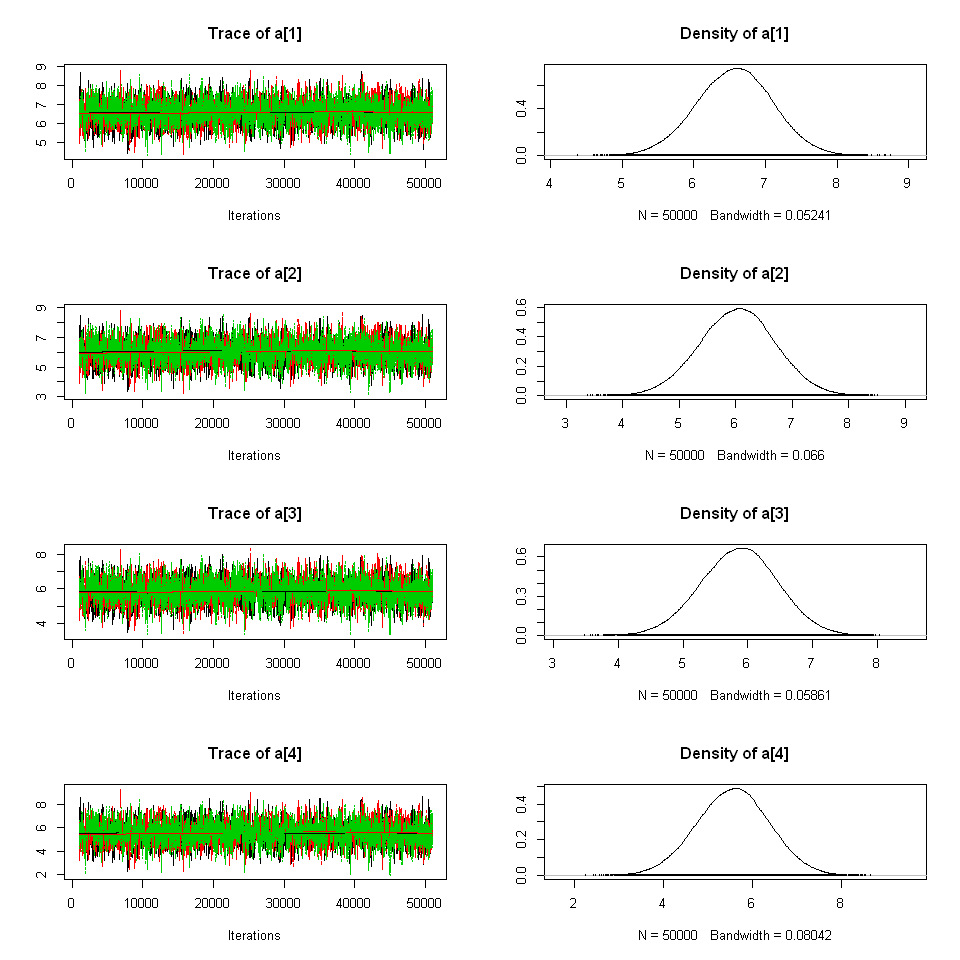

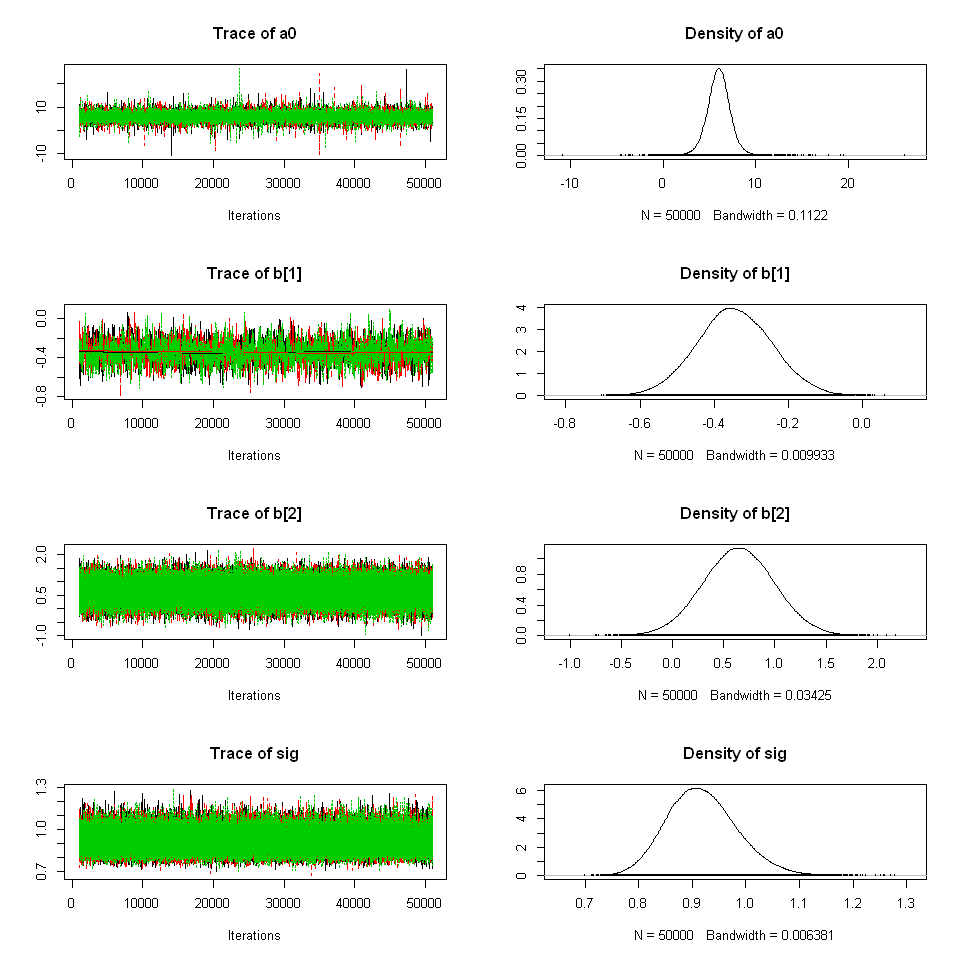

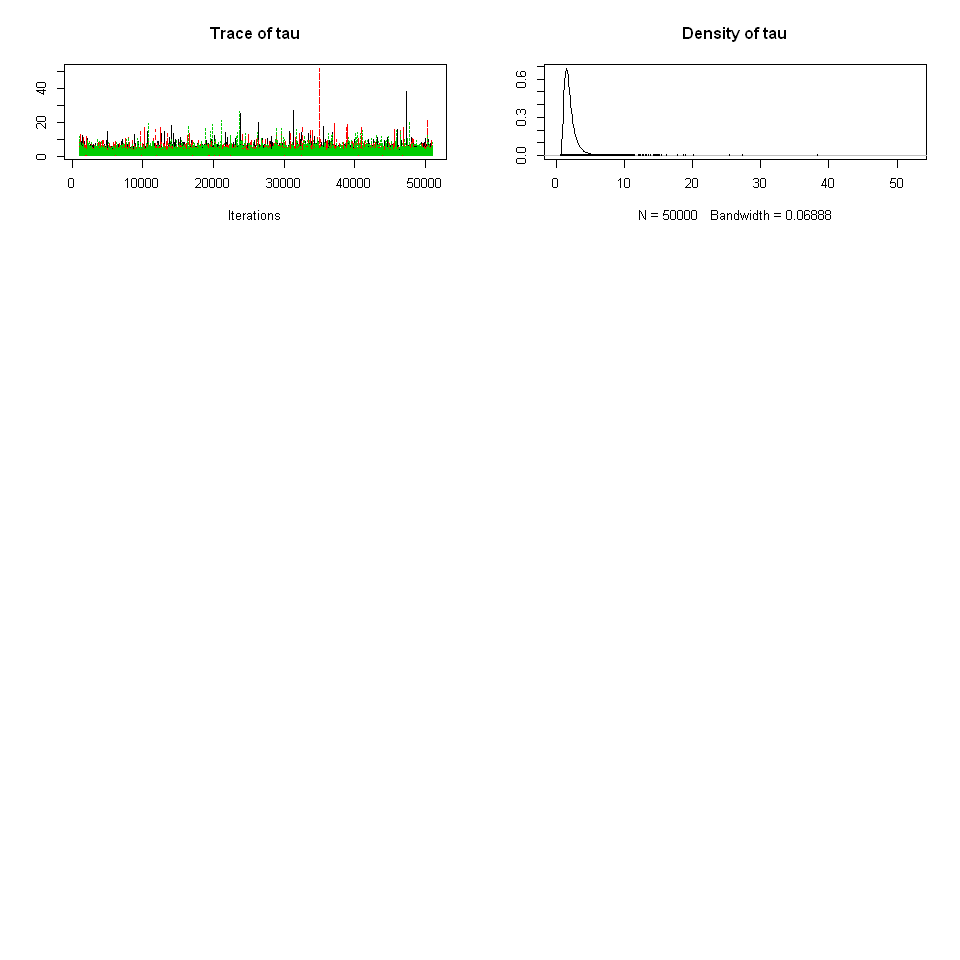

In [14]:
## convergence diagnostics

options(repr.plot.width = 8, repr.plot.height = 8)
plot(mod_sim)

In [15]:
gelman.diag(mod_sim)
autocorr.diag(mod_sim)
effectiveSize(mod_sim)

Potential scale reduction factors:

     Point est. Upper C.I.
a[1]          1       1.02
a[2]          1       1.02
a[3]          1       1.02
a[4]          1       1.02
a0            1       1.00
b[1]          1       1.02
b[2]          1       1.00
sig           1       1.00
tau           1       1.00

Multivariate psrf

1

,a[1],a[2],a[3],a[4],a0,b[1],b[2],sig,tau
Lag 0,1.0000000,1.0000000,1.0000000,1.0000000,1.00000000,1.0000000,1.00000000,1.000000000,1.000000000
Lag 1,0.9140874,0.9169641,0.9140737,0.9316910,0.24143596,0.9787614,0.13908273,0.057292665,0.290897317
Lag 5,0.8379852,0.8421458,0.8392763,0.8563172,0.22151229,0.8990801,0.03141883,0.006768778,0.003697781
Lag 10,0.7539798,0.7577096,0.7546810,0.7700936,0.19686248,0.8094526,0.02555055,0.002664368,0.004265488
Lag 50,0.3204154,0.3222988,0.3208460,0.3285087,0.08068789,0.3441306,0.01096599,-0.001531872,0.000281061


a[1]       a[2]       a[3]       a[4]         a0       b[1]       b[2] 
  1708.982   1680.767   1722.919   1670.286   7093.039   1599.451  40702.997 
       sig        tau 
124326.722  82795.787

# Results

In [16]:
dic.samples(mod, n.iter = 1e4)

Mean deviance:  213.7 
penalty 6.999 
Penalized deviance: 220.7 

It appears that this model is an improvement over the non-hierarchical one we fit earlier. Notice that the penalty term, which can be interpreted as the “effective” number of parameters, is less than the actual number of parameters (nine). There are fewer “effective” parameters because they are “sharing” information or “borrowing strength” from each other in the hierarhical structure. If we had skipped the hierarchy and fit one intercept, there would have been four parameters. If we had fit separate, independent intercepts for each region, there would have been seven parameters (which is close to what we ended up with).

In [17]:
summary(mod_sim)


Iterations = 1001:51000
Thinning interval = 1 
Number of chains = 3 
Sample size per chain = 50000 

1. Empirical mean and standard deviation for each variable,
   plus standard error of the mean:

        Mean     SD  Naive SE Time-series SE
a[1]  6.5709 0.5362 0.0013844      0.0129765
a[2]  6.0319 0.6768 0.0017475      0.0165096
a[3]  5.8677 0.6002 0.0015498      0.0144730
a[4]  5.5639 0.8265 0.0021340      0.0202255
a0    6.0101 1.3132 0.0033907      0.0156035
b[1] -0.3447 0.1018 0.0002630      0.0025467
b[2]  0.6462 0.3505 0.0009049      0.0017409
sig   0.9187 0.0657 0.0001696      0.0001864
tau   2.0448 1.0602 0.0027374      0.0036855

2. Quantiles for each variable:

         2.5%     25%     50%     75%   97.5%
a[1]  5.50363  6.2132  6.5781  6.9327  7.6108
a[2]  4.68979  5.5806  6.0406  6.4854  7.3472
a[3]  4.67698  5.4676  5.8750  6.2712  7.0323
a[4]  3.93167  5.0153  5.5745  6.1177  7.1668
a0    3.42952  5.2441  6.0175  6.7824  8.5622
b[1] -0.54216 -0.4128 -0.3462 -0.2767 -0.

In this particular model, the intercepts do not have a real interpretation because they correspond to the mean response for a country that does not produce oil and has \$0 log-income per capita (which is \$1 income per capita). We can interpret a0 as the overall mean intercept and $\tau$ as the standard deviation of intercepts across regions.

# Another Example

In [18]:
library("MASS")
data("OME")

dat = subset(OME, OME != "N/A")
dat$OME = factor(dat$OME) # relabel OME
dat$ID = as.numeric(factor(dat$ID)) # relabel ID so there are no gaps in numbers (they now go from 1 to 63)

In [19]:
head(OME)

ID,Age,OME,Loud,Noise,Correct,Trials
1,30,low,35,coherent,1,4
1,30,low,35,incoherent,4,5
1,30,low,40,coherent,0,3
1,30,low,40,incoherent,1,1
1,30,low,45,coherent,2,4
1,30,low,45,incoherent,2,2


In [20]:
## Original reference model and covariate matrix

mod_glm = glm(Correct/Trials ~ Age + OME + Loud + Noise, data=dat, weights=Trials, family="binomial")
X = model.matrix(mod_glm)[,-1]

In [21]:
## Original model with the Extension

mod_string = " model {
    for (i in 1:length(y)) {
        y[i] ~ dbin(phi[i], n[i])
        logit(phi[i]) = a[ID[i]] + b[1]*Age[i] + b[2]*OMElow[i] + b[3]*Loud[i] + b[4]*Noiseincoherent[i]
    }
    
    for(i in 1:max(ID)){
        a[i] ~ dnorm(mu, tau)
    }
    mu ~ dnorm(0, 1/1e2)
    tau ~ dgamma(1.0/2,1.0*1/2)
    for (j in 1:4) {
        b[j] ~ dnorm(0.0, 1.0/4.0^2)
    }

    sig = 1/tau
} "

data_jags = as.list(as.data.frame(X))
data_jags$y = dat$Correct
data_jags$n = dat$Trials
data_jags$ID = dat$ID

In [22]:
mod_n = jags.model(textConnection(mod_string), 
                   data = data_jags, 
                   n.chains = 3)

Compiling model graph
   Resolving undeclared variables
   Allocating nodes
Graph information:
   Observed stochastic nodes: 712
   Unobserved stochastic nodes: 69
   Total graph size: 6499

Initializing model



In [23]:
update(mod_n, 1e3)

In [24]:
params = c("a", "mu", "sig", "b")

In [25]:
mod_sim = coda.samples(model = mod_n, 
                       variable.names = params, 
                       n.iter = 1e4)

In [34]:
mod_csim = as.mcmc(do.call(rbind, mod_sim))

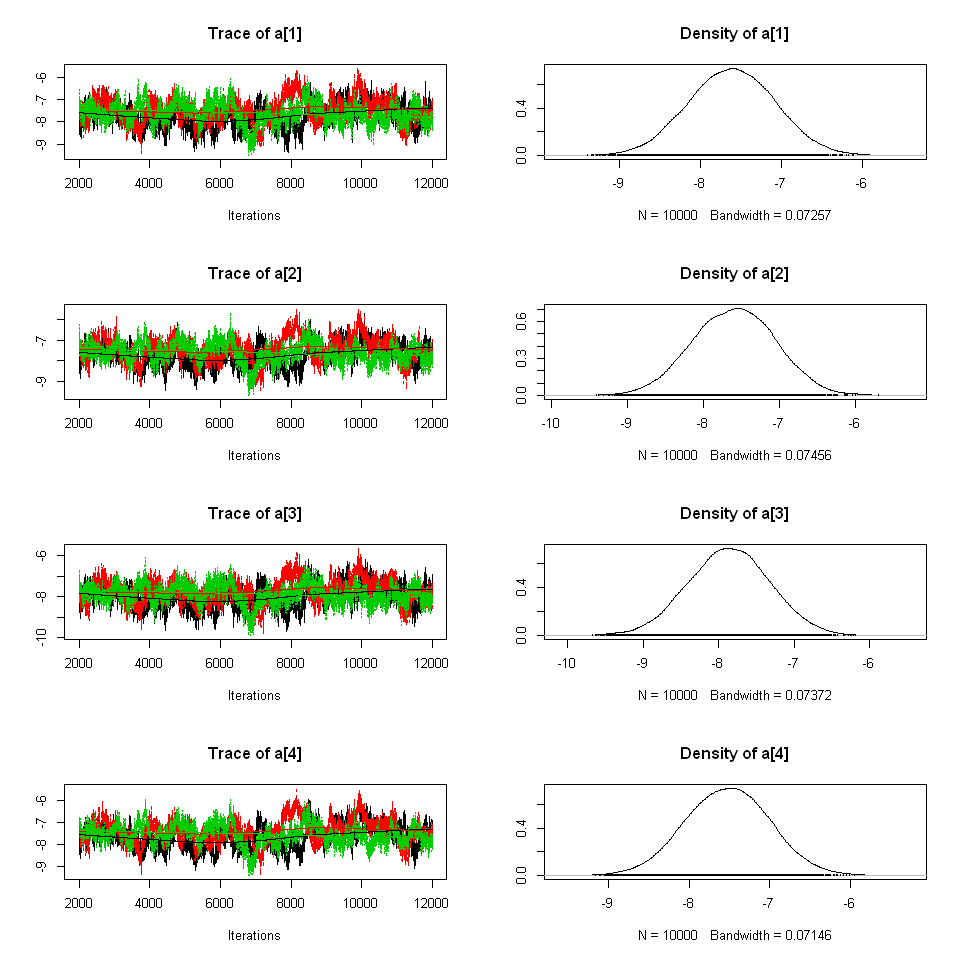

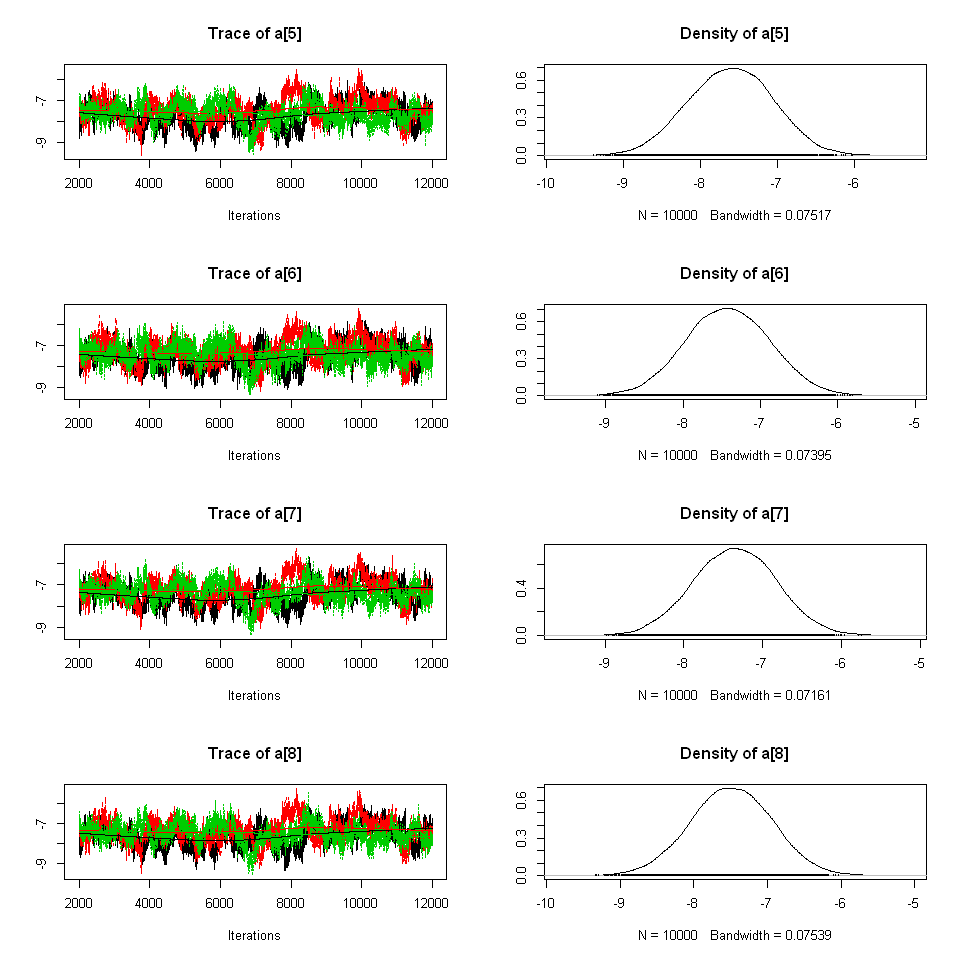

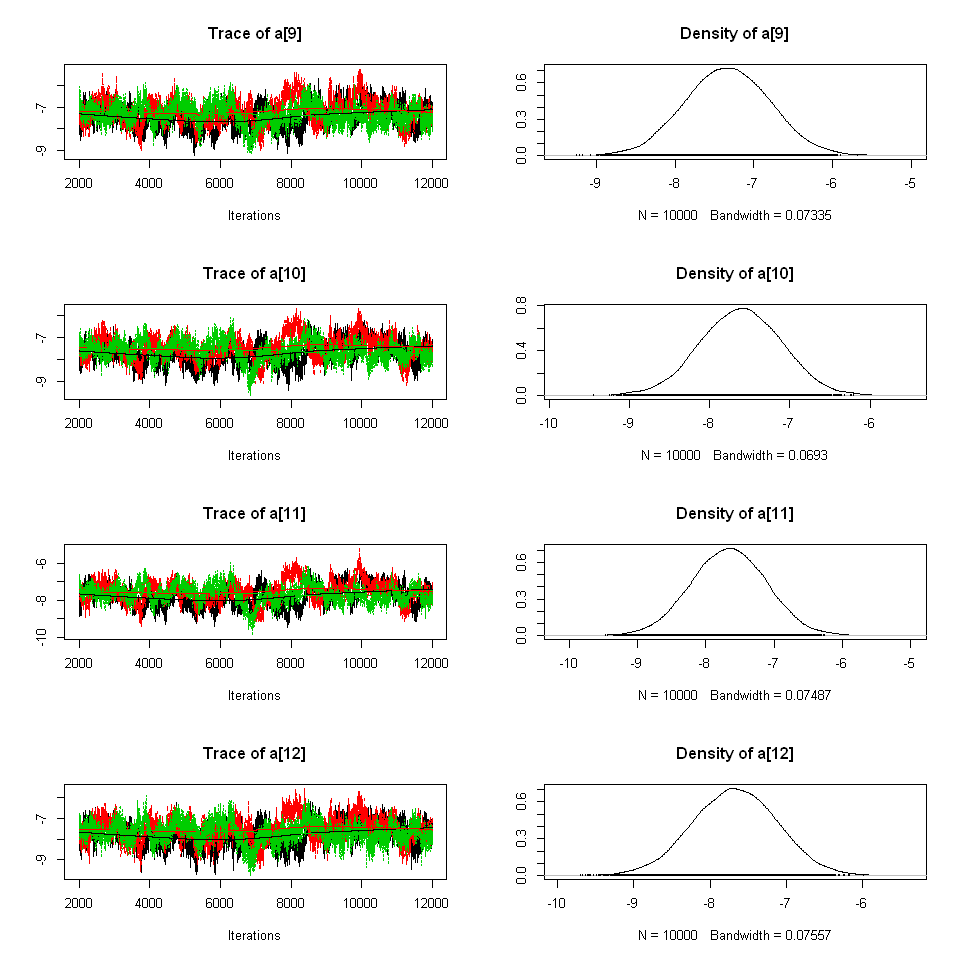

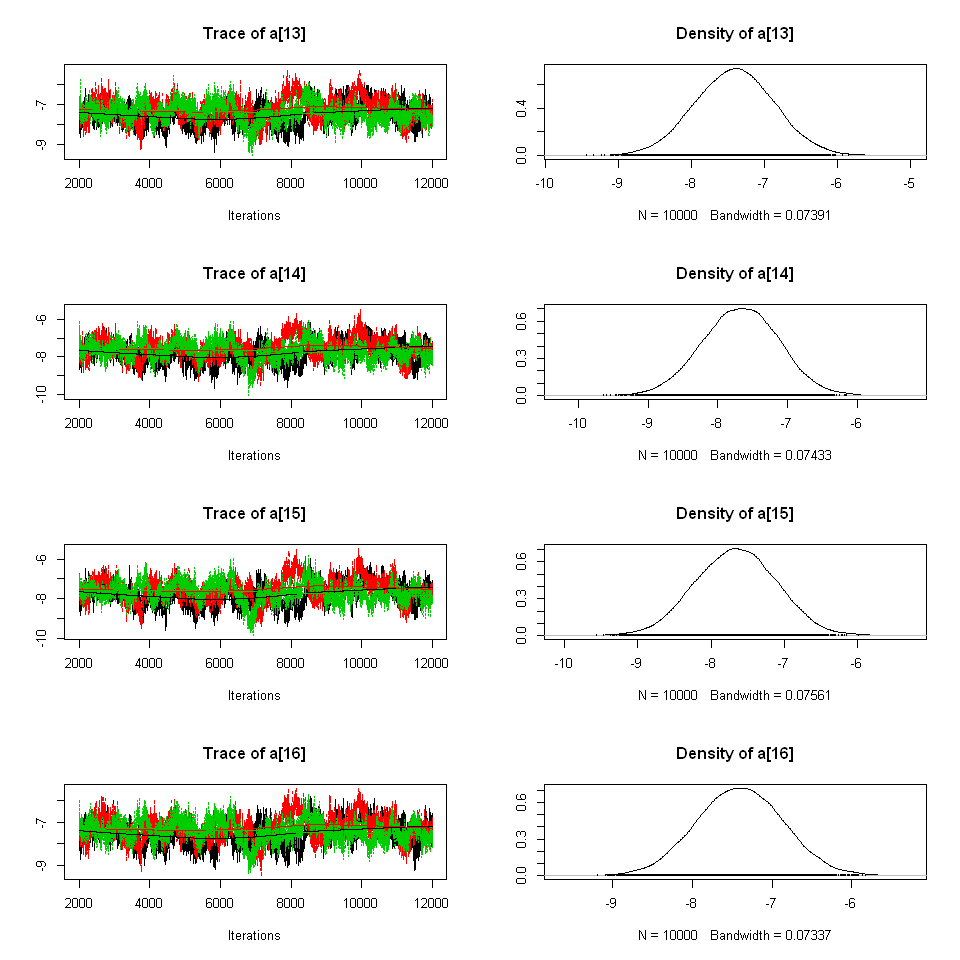

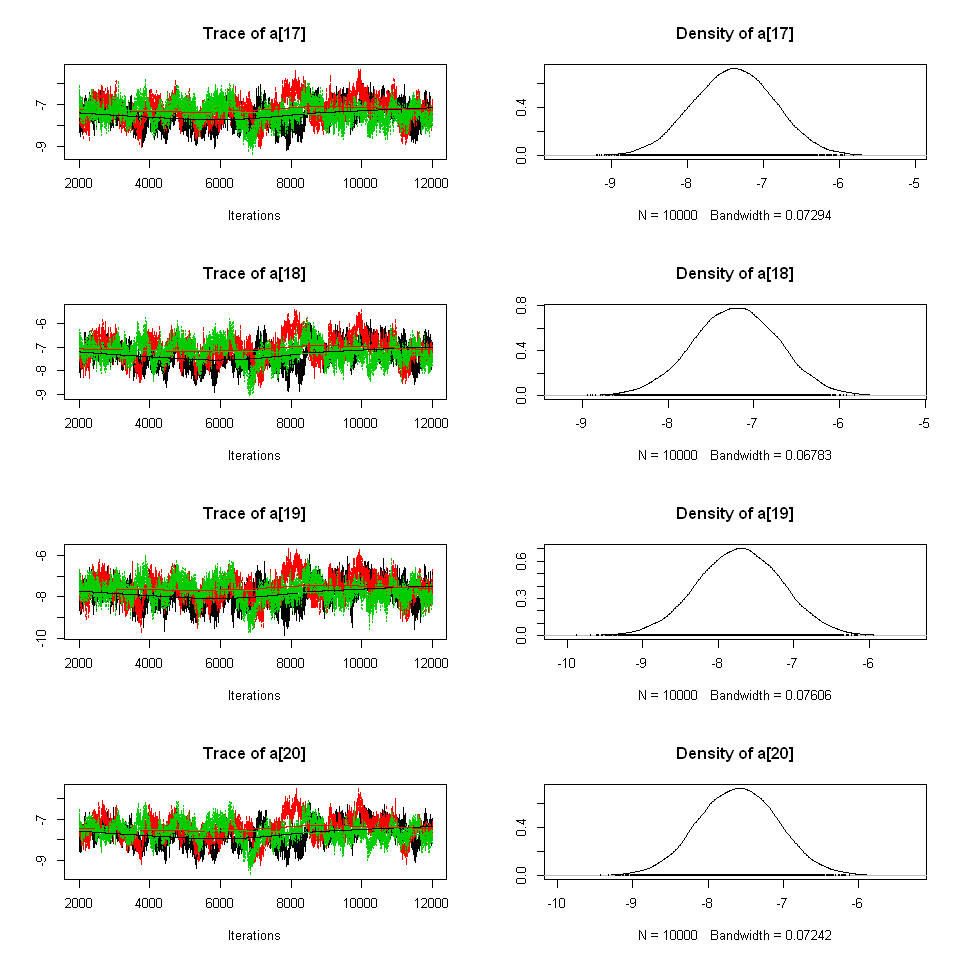

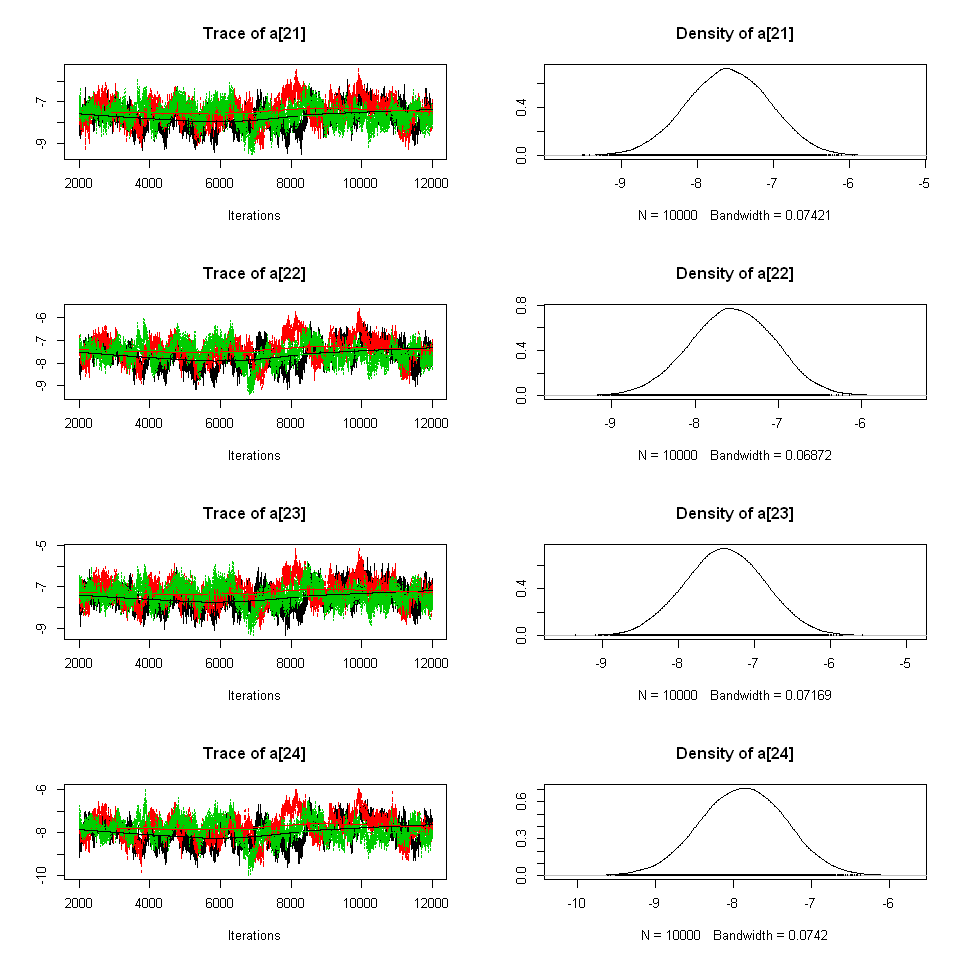

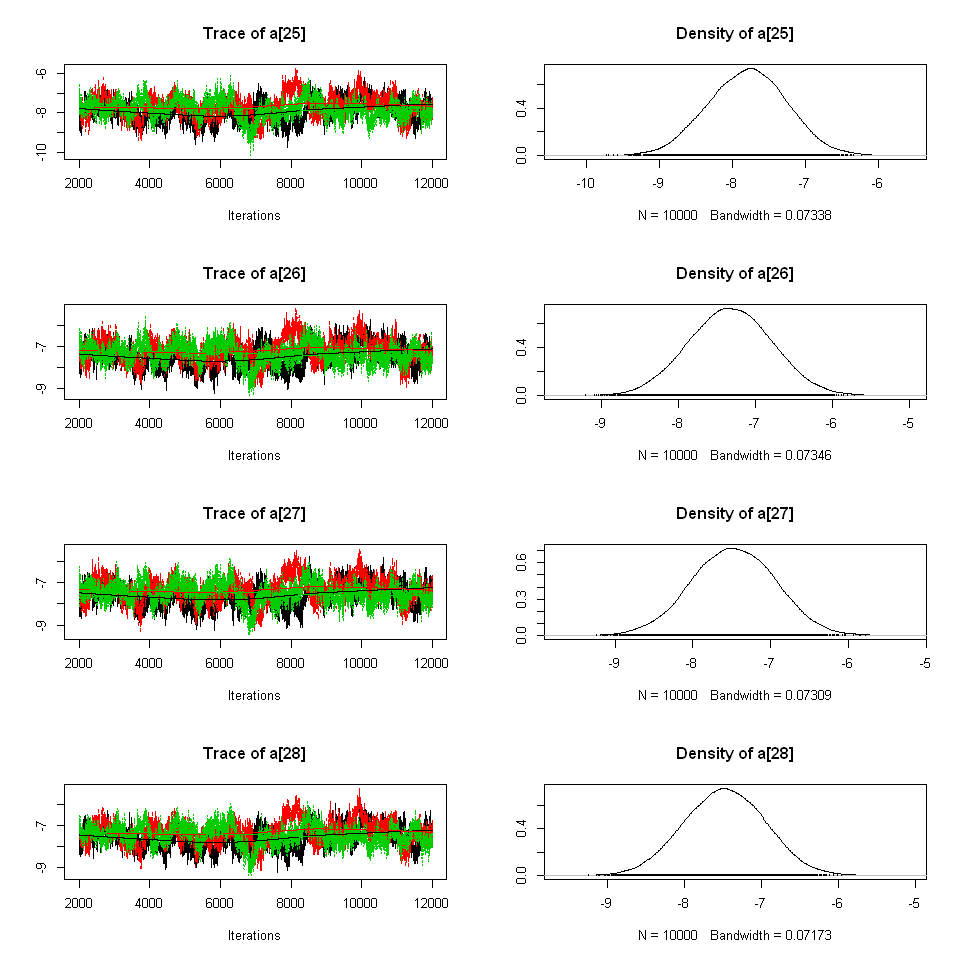

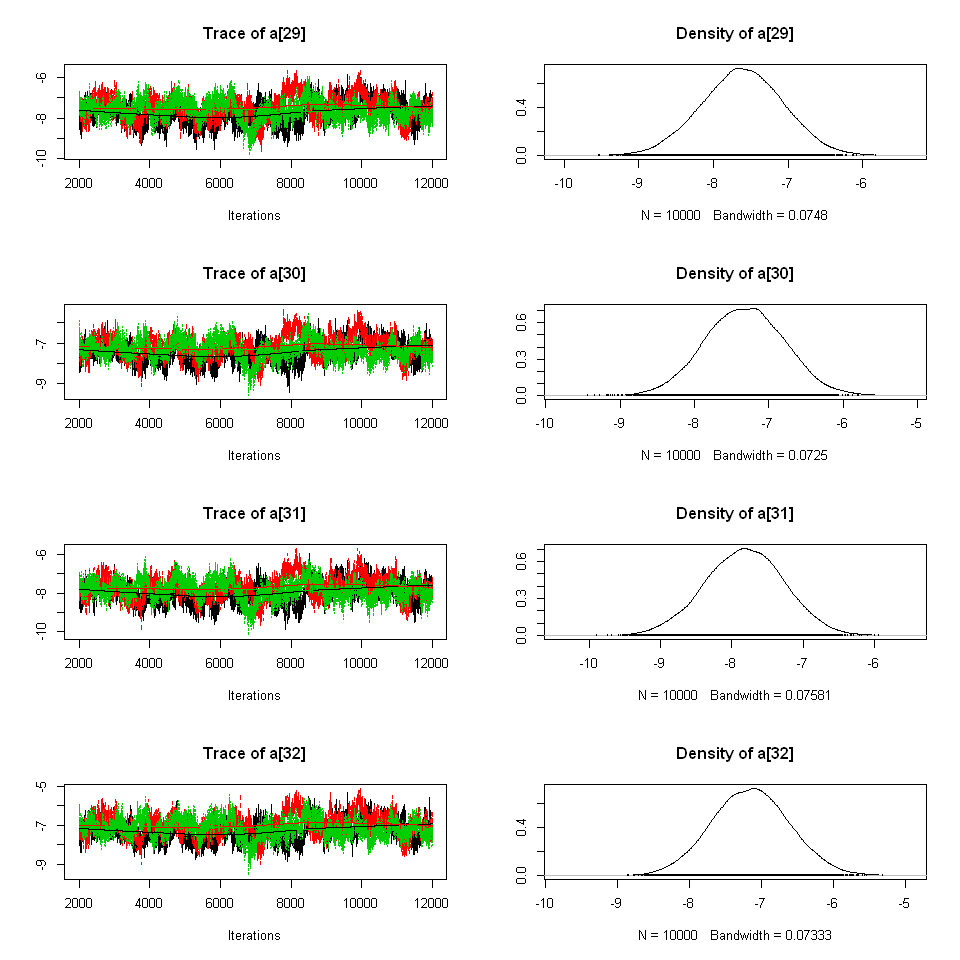

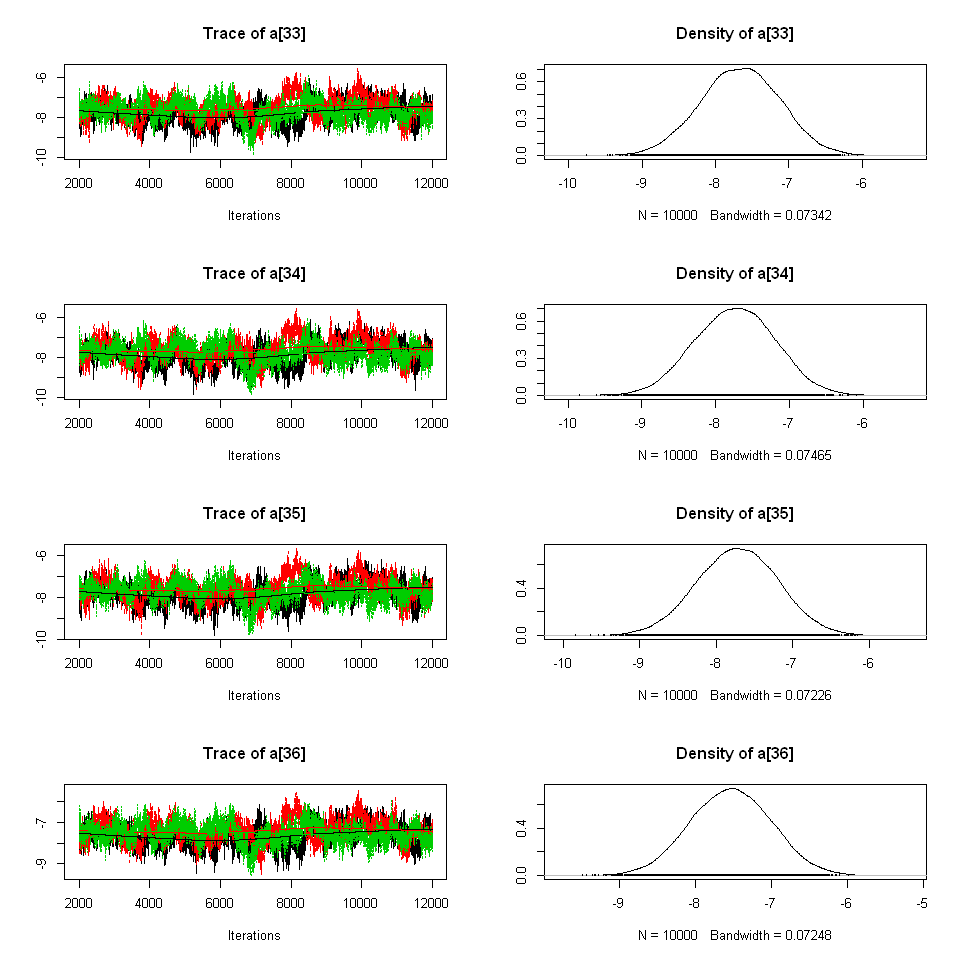

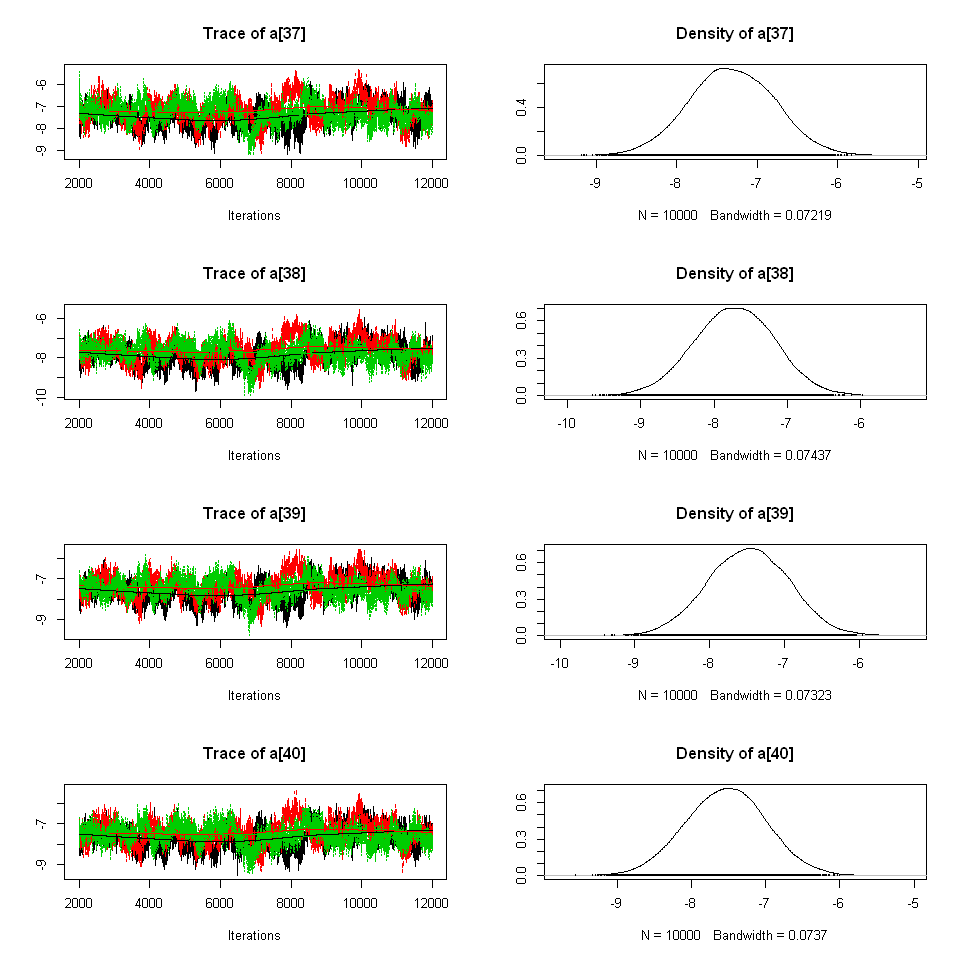

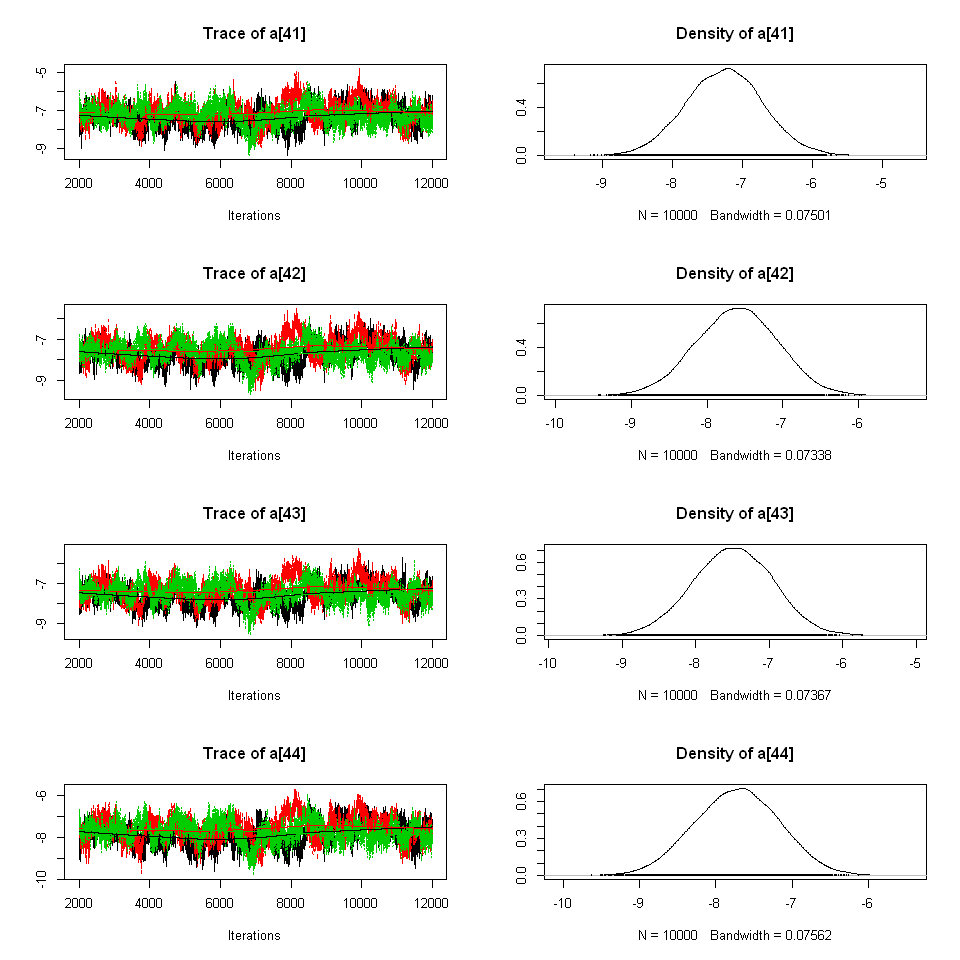

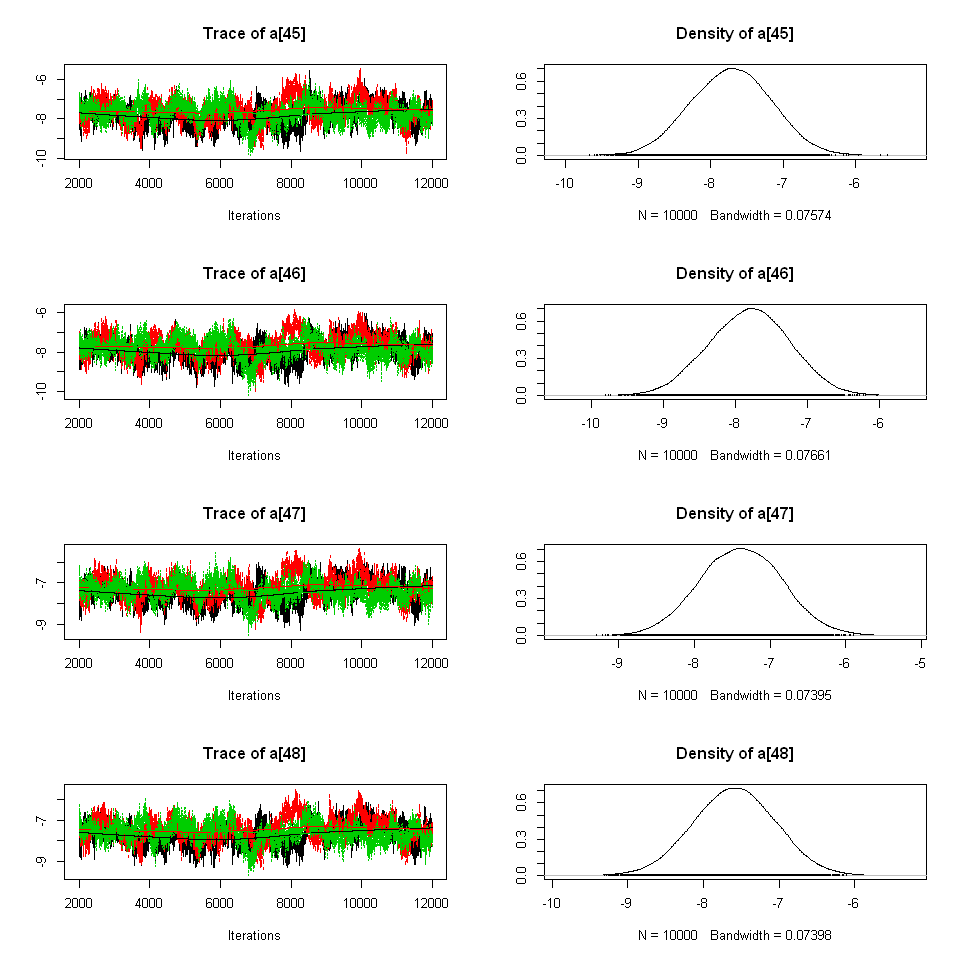

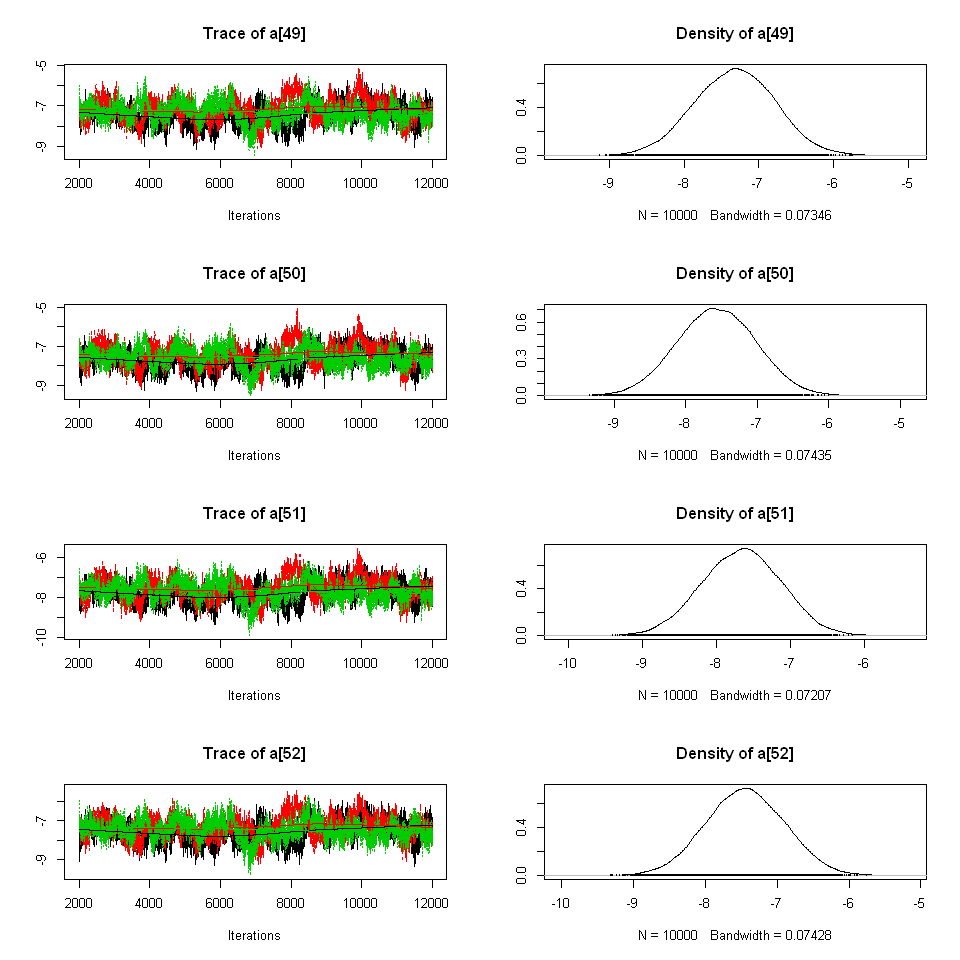

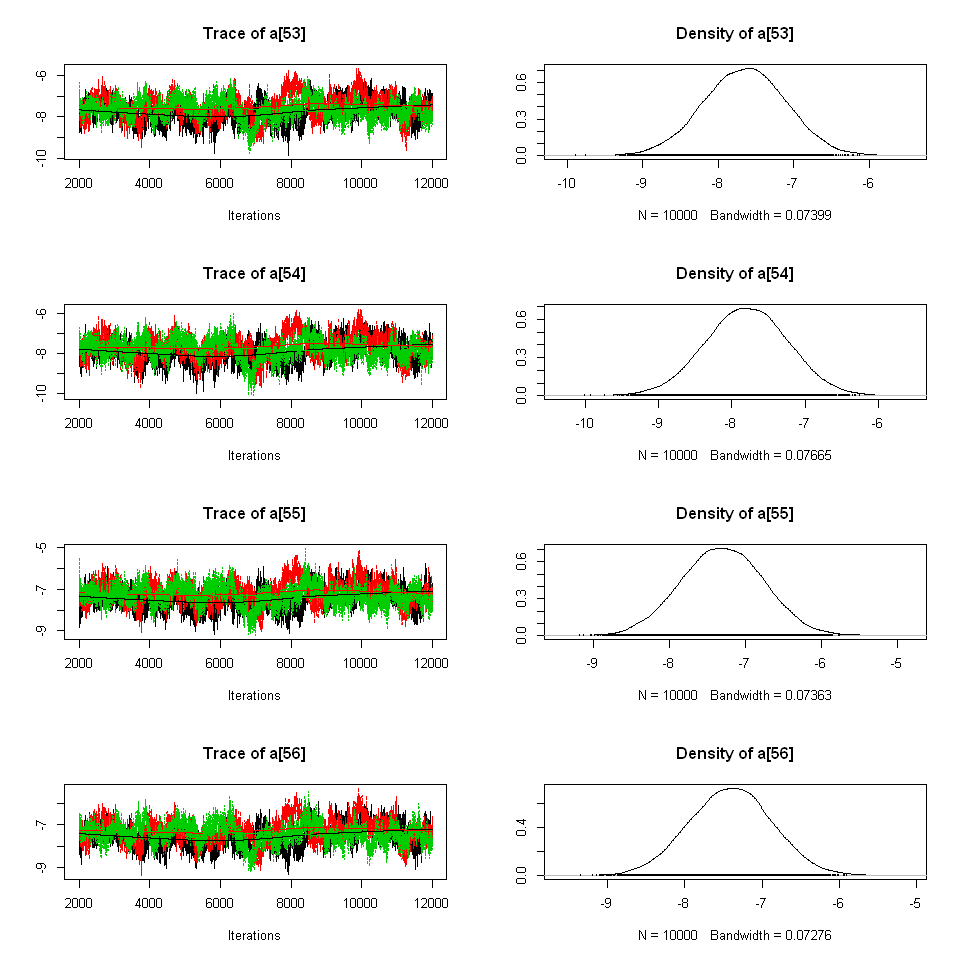

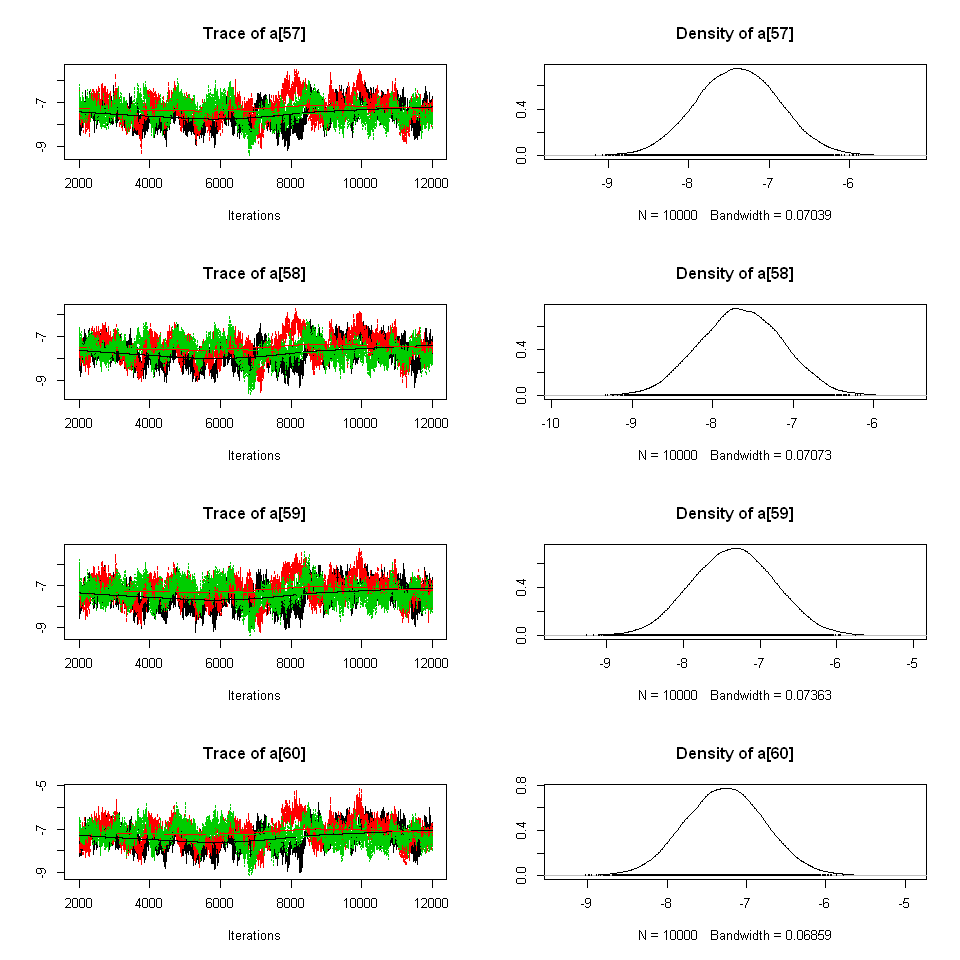

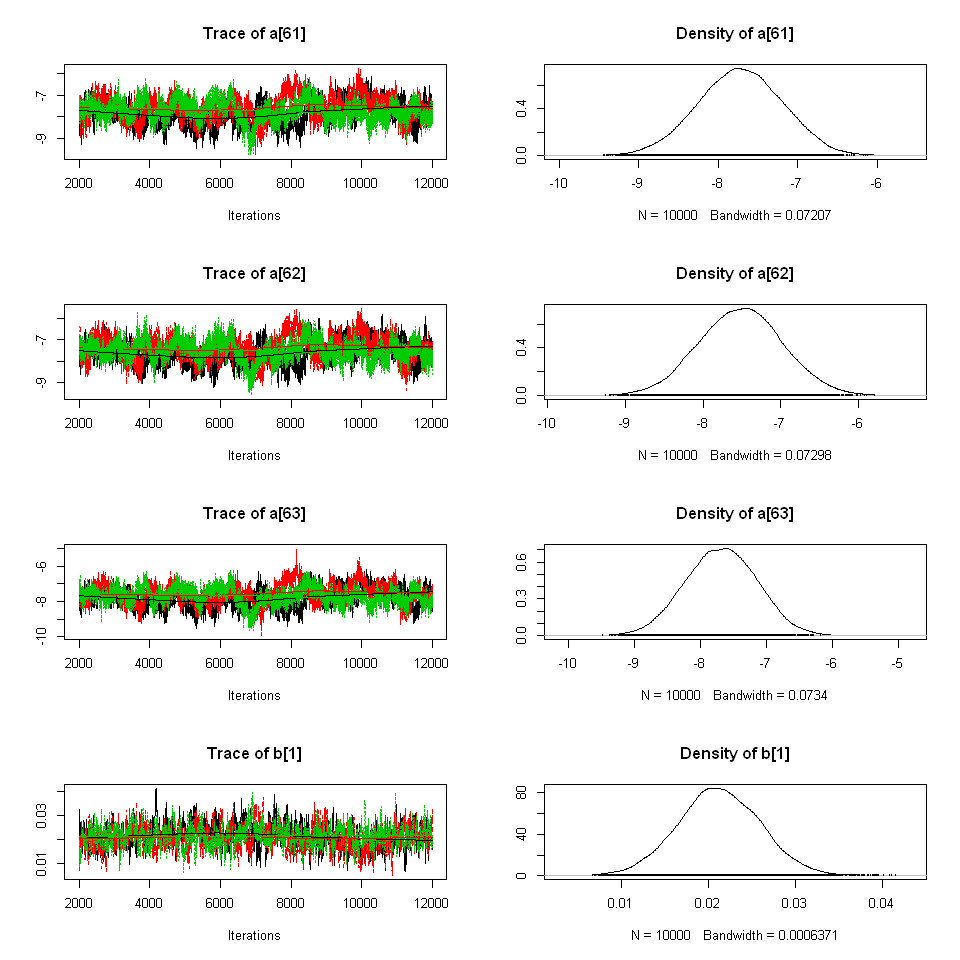

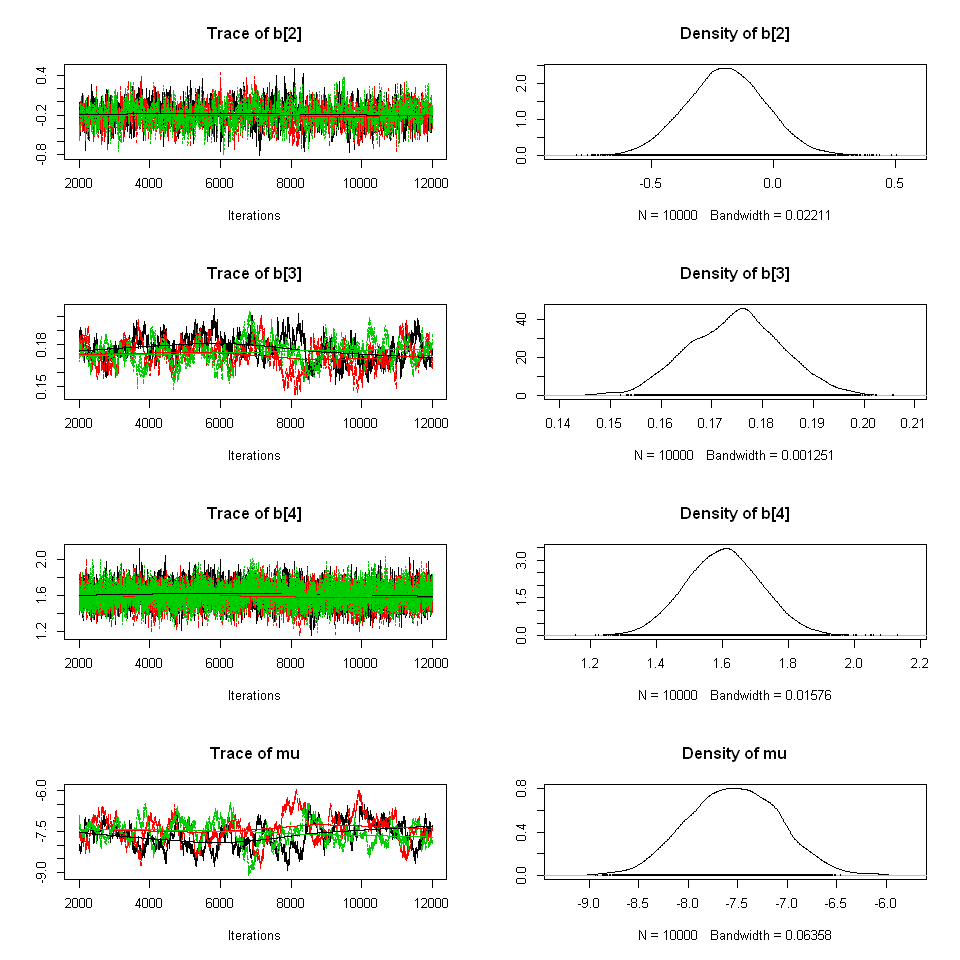

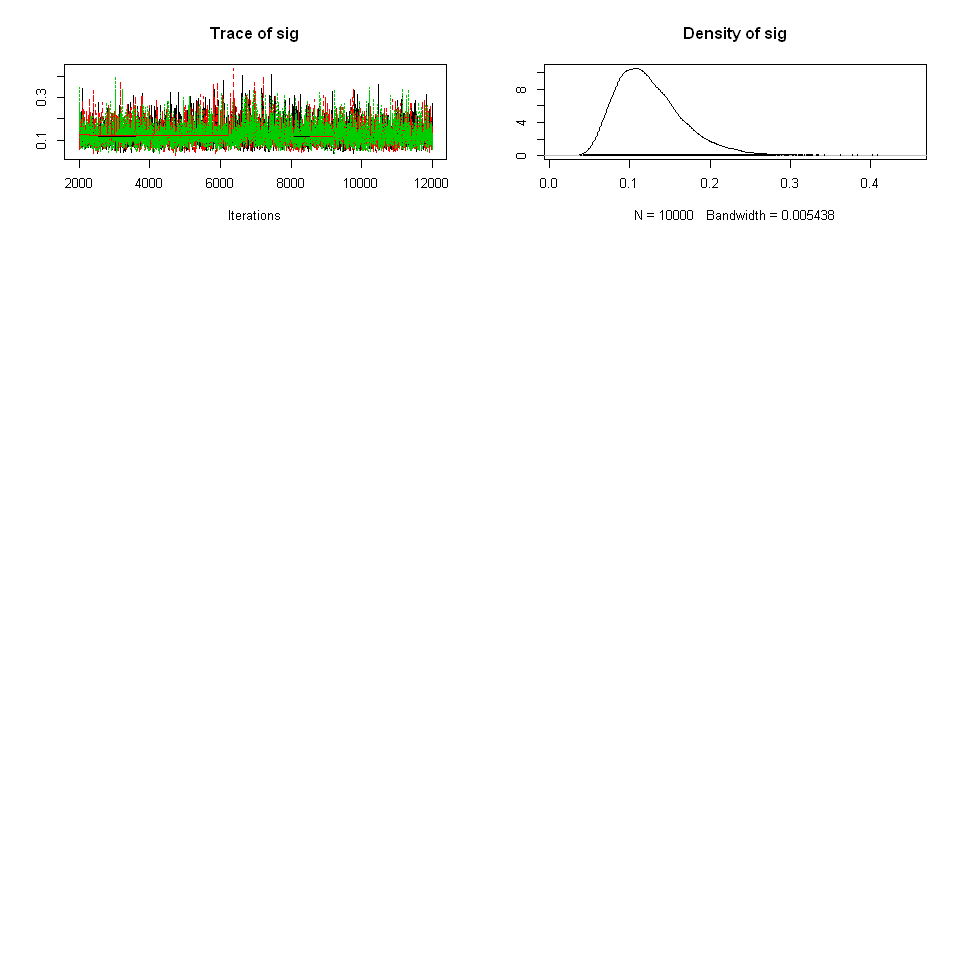

In [35]:
plot(mod_sim)

In [36]:
autocorr.diag(mod_sim)

,a[1],a[2],a[3],a[4],a[5],a[6],a[7],a[8],a[9],a[10],...,a[60],a[61],a[62],a[63],b[1],b[2],b[3],b[4],mu,sig
Lag 0,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,...,1.0000000,1.0000000,1.0000000,1.0000000,1.0000000,1.00000000,1.0000000,1.00000000,1.0000000,1.00000000
Lag 1,0.8372110,0.8432049,0.8191769,0.8803203,0.8582400,0.7824284,0.8554737,0.8365708,0.7901281,0.8309618,...,0.8057648,0.7907772,0.7695774,0.8152167,0.9460513,0.89584794,0.9852993,0.51013117,0.9902837,0.68634132
Lag 5,0.7720080,0.7757939,0.7412852,0.8267239,0.7916769,0.6932258,0.7904086,0.7680454,0.7027801,0.7545269,...,0.7308637,0.7092590,0.6868827,0.7373061,0.7685046,0.61088753,0.9339139,0.09384730,0.9735612,0.28320864
Lag 10,0.7534165,0.7536985,0.7164475,0.8060168,0.7724176,0.6781784,0.7729123,0.7516612,0.6831994,0.7338639,...,0.7121312,0.6958902,0.6746881,0.7214891,0.6064986,0.40416727,0.8802259,0.08042435,0.9528802,0.10347973
Lag 50,0.6249663,0.6272053,0.6024221,0.6696148,0.6354432,0.5633089,0.6369809,0.6217031,0.5641531,0.6139697,...,0.5953483,0.5851166,0.5569483,0.6110492,0.1985316,0.05671156,0.6591762,0.06350005,0.7962052,0.01404827


In [42]:
# Autocorrelation is so strong here.

In [37]:
gelman.diag(mod_sim)

Potential scale reduction factors:

      Point est. Upper C.I.
a[1]        1.07       1.23
a[2]        1.08       1.24
a[3]        1.07       1.21
a[4]        1.08       1.24
a[5]        1.08       1.24
a[6]        1.07       1.21
a[7]        1.08       1.24
a[8]        1.07       1.22
a[9]        1.07       1.21
a[10]       1.07       1.23
a[11]       1.07       1.23
a[12]       1.06       1.20
a[13]       1.07       1.22
a[14]       1.07       1.22
a[15]       1.07       1.22
a[16]       1.07       1.22
a[17]       1.07       1.23
a[18]       1.07       1.23
a[19]       1.06       1.20
a[20]       1.08       1.24
a[21]       1.07       1.21
a[22]       1.07       1.23
a[23]       1.07       1.21
a[24]       1.07       1.23
a[25]       1.07       1.21
a[26]       1.08       1.23
a[27]       1.07       1.22
a[28]       1.08       1.24
a[29]       1.07       1.20
a[30]       1.07       1.22
a[31]       1.06       1.20
a[32]       1.08       1.24
a[33]       1.07       1.22
a[34]       

In [38]:
raftery.diag(mod_sim)

[[1]]

Quantile (q) = 0.025
Accuracy (r) = +/- 0.005
Probability (s) = 0.95 
                                              
       Burn-in  Total  Lower bound  Dependence
       (M)      (N)    (Nmin)       factor (I)
 a[1]  42       47817  3746         12.80     
 a[2]  40       47928  3746         12.80     
 a[3]  25       26960  3746          7.20     
 a[4]  72       75474  3746         20.10     
 a[5]  24       30640  3746          8.18     
 a[6]  15       17496  3746          4.67     
 a[7]  30       34656  3746          9.25     
 a[8]  42       48798  3746         13.00     
 a[9]  36       40908  3746         10.90     
 a[10] 36       33672  3746          8.99     
 a[11] 60       53600  3746         14.30     
 a[12] 7        8197   3746          2.19     
 a[13] 20       19140  3746          5.11     
 a[14] 20       20940  3746          5.59     
 a[15] 25       33330  3746          8.90     
 a[16] 28       33446  3746          8.93     
 a[17] 25       26415  3746   

In [41]:
dic.samples(model = mod_n, n.iter = 5e3)

Mean deviance:  1241 
penalty 28.67 
Penalized deviance: 1269 

In case oforiginal model ie. without random intercepts, it has DIC value equal to 1263. Here DIC value is higher than original model, so originlam odel is prefered over this model. 
One another important thing to observe is that in this case our model has 69 parametrs but the effectiveno of parametrs are 28.67. This shows that a lot of parameters are sharing the information or we can say there is a sort of redundancy in the information associated with the parameters.